In [27]:
# Cell 1: Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pickle
import seaborn as sns

In [28]:
# Cell 2: Setup
DATA_DIR = "faceshape/published_dataset"
LABELS = os.listdir(DATA_DIR)

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)


I0000 00:00:1750494758.991633   72611 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2


In [29]:
# Cell 3: Feature extraction function
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)

    if not results.multi_face_landmarks:
        return None

    landmarks = results.multi_face_landmarks[0].landmark

    def dist(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    try:
        forehead = [landmarks[10].x, landmarks[10].y]
        chin = [landmarks[152].x, landmarks[152].y]
        left_jaw = [landmarks[234].x, landmarks[234].y]
        right_jaw = [landmarks[454].x, landmarks[454].y]
        left_temple = [landmarks[127].x, landmarks[127].y]
        right_temple = [landmarks[356].x, landmarks[356].y]

        face_length = dist(forehead, chin)
        jaw_width = dist(left_jaw, right_jaw)
        forehead_width = dist(left_temple, right_temple)

        face_ratio = jaw_width / face_length
        forehead_jaw_diff = forehead_width - jaw_width

        return [face_length, jaw_width, forehead_width, face_ratio, forehead_jaw_diff]
    except:
        return None


W0000 00:00:1750494759.002254   83048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1750494759.010719   83048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [30]:
# Cell 3: Feature extraction function
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)

    if not results.multi_face_landmarks:
        return None

    landmarks = results.multi_face_landmarks[0].landmark

    def dist(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    try:
        forehead = [landmarks[10].x, landmarks[10].y]
        chin = [landmarks[152].x, landmarks[152].y]
        left_jaw = [landmarks[234].x, landmarks[234].y]
        right_jaw = [landmarks[454].x, landmarks[454].y]
        left_temple = [landmarks[127].x, landmarks[127].y]
        right_temple = [landmarks[356].x, landmarks[356].y]

        face_length = dist(forehead, chin)
        jaw_width = dist(left_jaw, right_jaw)
        forehead_width = dist(left_temple, right_temple)

        face_ratio = jaw_width / face_length
        forehead_jaw_diff = forehead_width - jaw_width

        return [face_length, jaw_width, forehead_width, face_ratio, forehead_jaw_diff]
    except:
        return None


In [31]:
# Cell 4: Collect data
X = []
y = []

for label in LABELS:
    folder = os.path.join(DATA_DIR, label)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        features = extract_features(path)
        if features:
            X.append(features)
            y.append(label)

print(f"Total samples collected: {len(X)}")


Total samples collected: 500


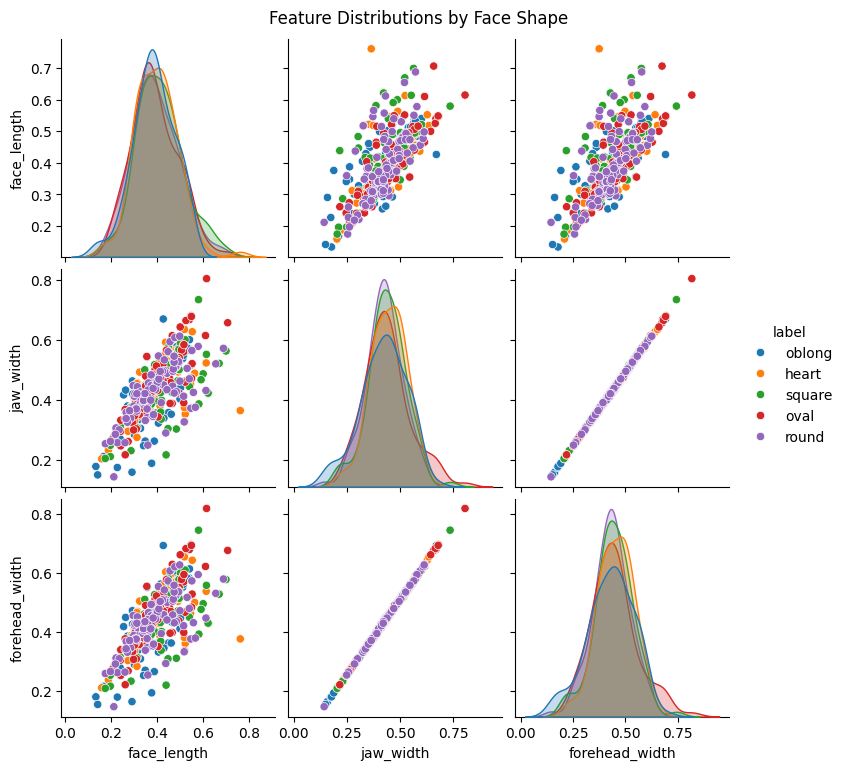

In [32]:
# Cell 5: Visualize one feature distribution
df_plot = {
    "face_length": [x[0] for x in X],
    "jaw_width": [x[1] for x in X],
    "forehead_width": [x[2] for x in X],
    "label": y
}
import pandas as pd
df = pd.DataFrame(df_plot)

sns.pairplot(df, hue="label")
plt.suptitle("Feature Distributions by Face Shape", y=1.02)
plt.show()


In [33]:
# Cell 6: Train/test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

       heart       0.19      0.29      0.23        14
      oblong       0.44      0.25      0.32        28
        oval       0.36      0.33      0.35        24
       round       0.25      0.17      0.20        24
      square       0.16      0.40      0.23        10

    accuracy                           0.27       100
   macro avg       0.28      0.29      0.26       100
weighted avg       0.31      0.27      0.28       100



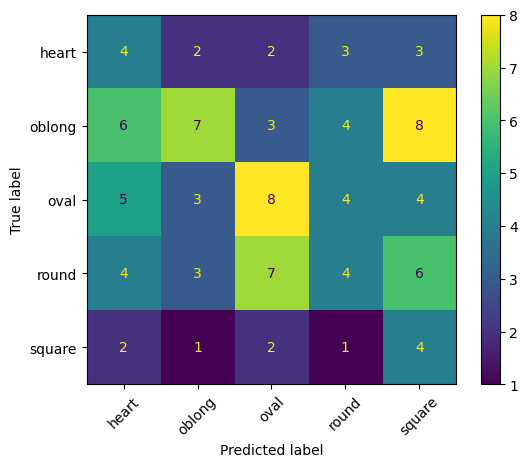

In [34]:
# Cell 7: Evaluation
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45)
plt.show()


In [40]:
# Cell 8: Save the model
with open("face_shape_classifier.pkl", "wb") as f:
    pickle.dump(clf, f)

print("Model saved as face_shape_classifier.pkl")


Model saved as face_shape_classifier.pkl


In [ ]:
def visualize_face_metrics_on_all(data_dir, model, max_samples_per_label=5):
    import os
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    labels = sorted(os.listdir(data_dir))
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

    def dist(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    for label in labels:
        folder = os.path.join(data_dir, label)
        if not os.path.isdir(folder):
            continue

        files = sorted(os.listdir(folder))[:max_samples_per_label]
        print(f"\n🔍 Analyzing label: {label} — {len(files)} samples")

        for filename in files:
            image_path = os.path.join(folder, filename)
            img = cv2.imread(image_path)
            if img is None:
                print(f"⚠️ Could not read image: {filename}")
                continue

            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(rgb)
            if not results.multi_face_landmarks:
                print(f"❌ No face detected in: {filename}")
                continue

            landmarks = results.multi_face_landmarks[0].landmark
            h, w, _ = img.shape

            # Points
            pts = {
                "forehead": [landmarks[10].x * w, landmarks[10].y * h],
                "chin": [landmarks[152].x * w, landmarks[152].y * h],
                "left_jaw": [landmarks[234].x * w, landmarks[234].y * h],
                "right_jaw": [landmarks[454].x * w, landmarks[454].y * h],
                "left_temple": [landmarks[127].x * w, landmarks[127].y * h],
                "right_temple": [landmarks[356].x * w, landmarks[356].y * h]
            }

            # Metrics
            face_length = dist(pts["forehead"], pts["chin"])
            jaw_width = dist(pts["left_jaw"], pts["right_jaw"])
            forehead_width = dist(pts["left_temple"], pts["right_temple"])
            face_ratio = jaw_width / face_length
            forehead_jaw_diff = forehead_width - jaw_width

            features = [[face_length, jaw_width, forehead_width, face_ratio, forehead_jaw_diff]]
            pred_shape = model.predict(features)[0]

            # Start visualization
            fig, ax = plt.subplots(figsize=(6.5, 6.5))
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.axis("off")

            # Draw key lines
            def draw_line(pt1, pt2, color, label):
                ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color=color, linewidth=2)
                mx, my = (pt1[0] + pt2[0]) / 2, (pt1[1] + pt2[1]) / 2
                ax.text(mx, my, label, color=color, fontsize=10, backgroundcolor="white")

            draw_line(pts["forehead"], pts["chin"], "green", "Face Length")
            draw_line(pts["left_jaw"], pts["right_jaw"], "blue", "Jaw Width")
            draw_line(pts["left_temple"], pts["right_temple"], "red", "Forehead Width")

            # Draw landmark points
            for name, pt in pts.items():
                ax.scatter(*pt, color='orange')
                ax.text(pt[0]+2, pt[1]-2, name, fontsize=8, color='black', backgroundcolor='white')

            # Metric box
            metric_text = (
                f"📏 Face Length  : {face_length:.2f}\n"
                f"📐 Jaw Width    : {jaw_width:.2f}\n"
                f"🧠 Forehead     : {forehead_width:.2f}\n"
                f"📊 Face Ratio   : {face_ratio:.3f}\n"
                f"🔁 Forehead-Jaw : {forehead_jaw_diff:.3f}"
            )
            ax.text(0.02, 0.02, metric_text, fontsize=10,
                    transform=ax.transAxes, va="top",
                    bbox=dict(facecolor='white', alpha=0.8))

            # Prediction result
            correct = label.lower() == pred_shape.lower()
            result_color = "green" if correct else "red"
            result_text = f"✅ Predicted: {pred_shape}" if correct else f"❌ Predicted: {pred_shape} (Expected: {label})"
            ax.text(0.5, 0.96, result_text, fontsize=12, transform=ax.transAxes,
                    ha="center", color='white', bbox=dict(facecolor=result_color, alpha=0.9))

            plt.tight_layout()
            plt.show()



🔍 Label: oblong — Showing 3 samples


I0000 00:00:1750495283.113002   72611 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1750495283.116111   93432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750495283.121408   93432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


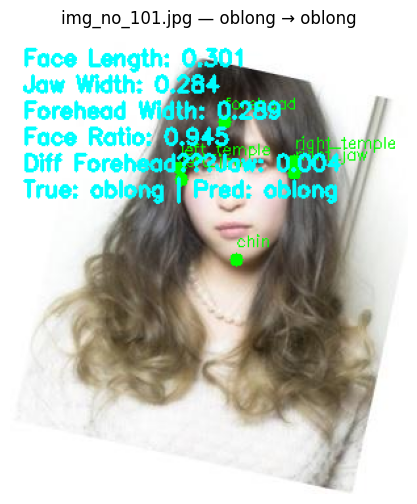

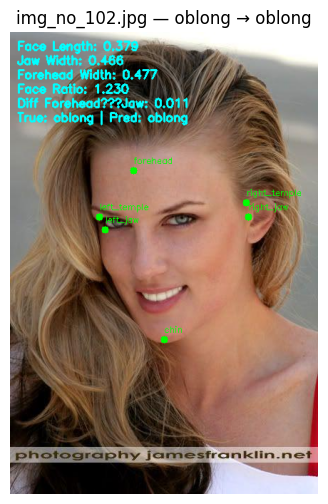

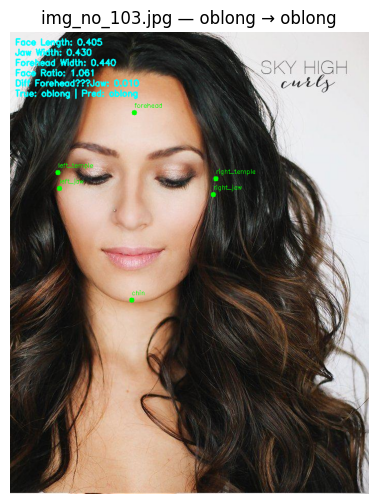


🔍 Label: heart — Showing 3 samples


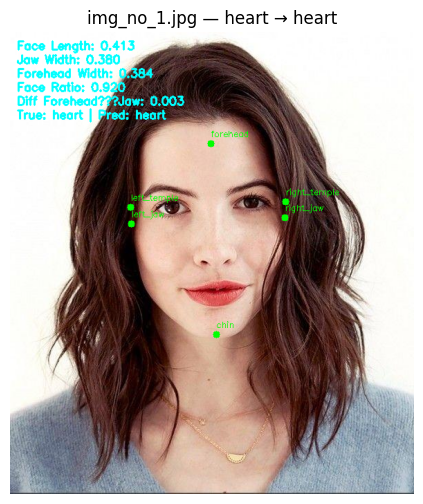

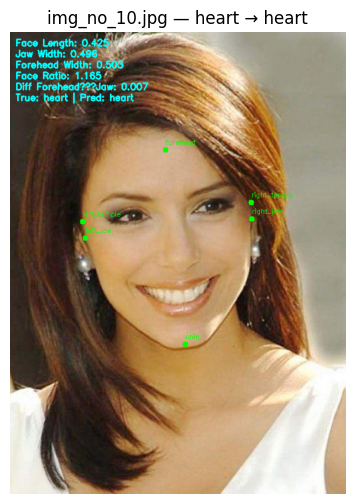

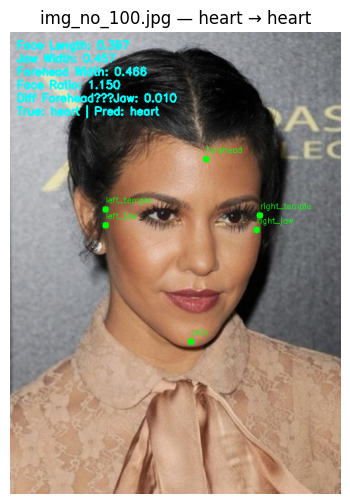


🔍 Label: square — Showing 3 samples


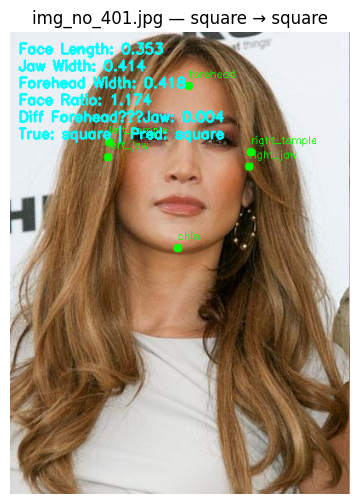

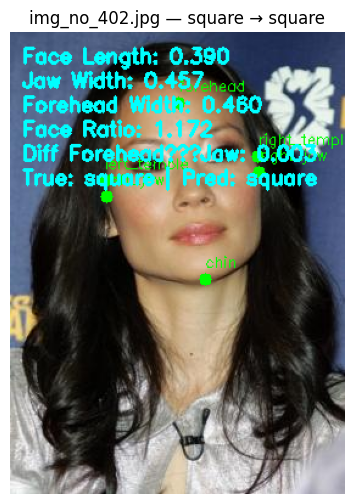

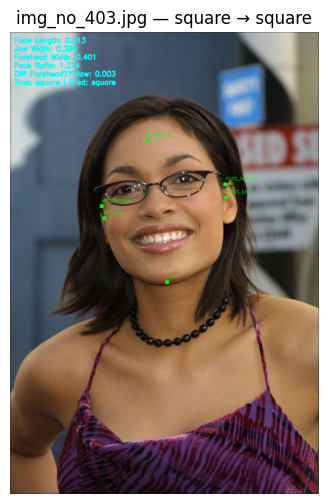


🔍 Label: oval — Showing 3 samples


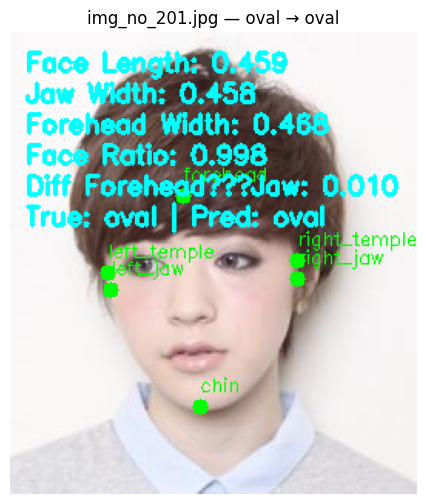

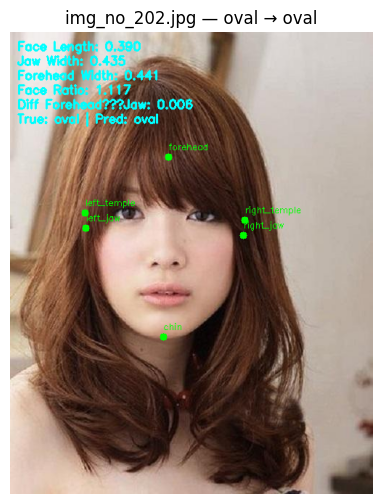

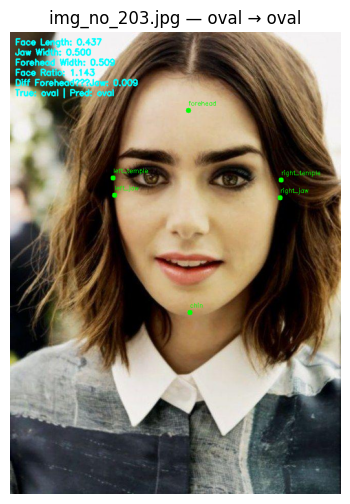


🔍 Label: round — Showing 3 samples


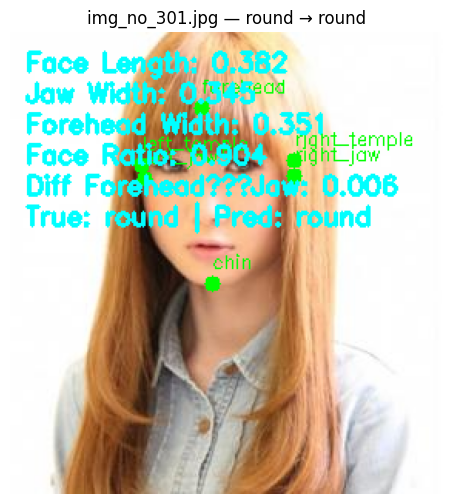

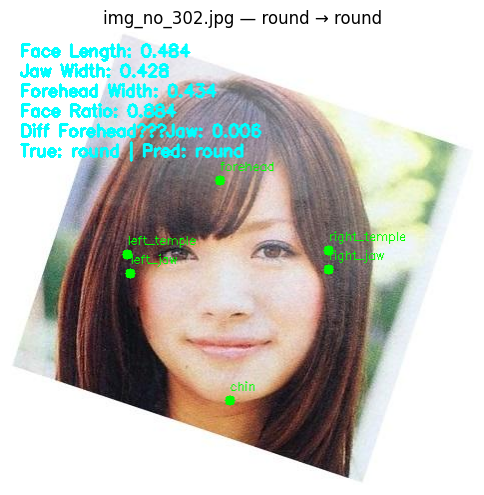

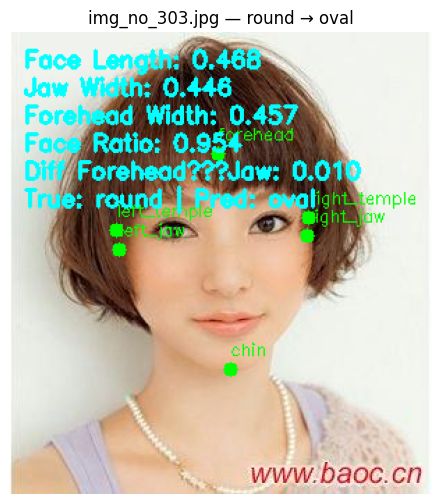

In [50]:
with open("face_shape_classifier.pkl", "rb") as f:
    model = pickle.load(f)

visualize_face_metrics_on_all("faceshape/published_dataset", model, max_samples_per_label=3)
